In [1]:
from dataclasses import dataclass
from matplotlib import animation
from scipy.interpolate import interp1d
import imufusion
import matplotlib.pyplot as pyplot
from mpl_toolkits import mplot3d
import numpy as np


/home/naveenb/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import sensor data ("short_walk.csv" or "long_walk.csv")
data = np.genfromtxt("/home/naveenb/vital_ws/EP6/Gait-Tracking/data_july_02_proc_kush_2.csv", delimiter=",", skip_header=1)



timestamp = data[:, 0]
gyroscope = data[:, 1:4]
accelerometer = data[:, 4:7]
magnetometer = data[:, 7:10]

In [3]:
import numpy
sample_rate = 400  # 400 Hz
# Instantiate AHRS algorithms
offset = imufusion.Offset(sample_rate)
ahrs = imufusion.Ahrs()

ahrs.settings = imufusion.Settings(imufusion.CONVENTION_NWU,
                                   0.5,  # gain
                                   2000,  # gyroscope range
                                   10,  # acceleration rejection
                                   8,  # magnetic rejection
                                   5 * sample_rate)  # rejection timeout = 5 seconds

# Process sensor data
delta_time = numpy.diff(timestamp, prepend=timestamp[0])

euler = numpy.empty((len(timestamp), 3))
internal_states = numpy.empty((len(timestamp), 3))
acceleration = numpy.empty((len(timestamp), 3))

In [4]:
# for index in range(len(timestamp)):
#     gyroscope[index] = offset.update(gyroscope[index])

#     ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], delta_time[index])

#     euler[index] = ahrs.quaternion.to_euler()

#     ahrs_internal_states = ahrs.internal_states
#     internal_states[index] = numpy.array([ahrs_internal_states.acceleration_error,
#                                           ahrs_internal_states.accelerometer_ignored,
#                                           ahrs_internal_states.acceleration_recovery_trigger])

#     acceleration[index] = 9.81 * ahrs.earth_acceleration  # convert g to m/s/s


# for magnetometer
for index in range(len(timestamp)):
    gyroscope[index] = offset.update(gyroscope[index])

    ahrs.update(gyroscope[index], accelerometer[index], magnetometer[index], delta_time[index])

    euler[index] = ahrs.quaternion.to_euler()

    ahrs_internal_states = ahrs.internal_states
    internal_states[index] = numpy.array([ahrs_internal_states.acceleration_error,
                                          ahrs_internal_states.accelerometer_ignored,
                                          ahrs_internal_states.acceleration_recovery_trigger])

    acceleration[index] = 9.81 * ahrs.earth_acceleration  # convert g to m/s/s


In [5]:
# Plot sensor data
figure, axes = pyplot.subplots(nrows=6, sharex=True, gridspec_kw={"height_ratios": [6, 6, 6, 2, 1, 1]})

figure.suptitle("Sensors data, Euler angles, and AHRS internal states")

axes[0].plot(timestamp, gyroscope[:, 0], "tab:red", label="Gyroscope X")
axes[0].plot(timestamp, gyroscope[:, 1], "tab:green", label="Gyroscope Y")
axes[0].plot(timestamp, gyroscope[:, 2], "tab:blue", label="Gyroscope Z")
axes[0].set_ylabel("Degrees/s")
axes[0].grid()
axes[0].legend()

axes[1].plot(timestamp, accelerometer[:, 0], "tab:red", label="Accelerometer X")
axes[1].plot(timestamp, accelerometer[:, 1], "tab:green", label="Accelerometer Y")
axes[1].plot(timestamp, accelerometer[:, 2], "tab:blue", label="Accelerometer Z")
axes[1].set_ylabel("g")
axes[1].grid()
axes[1].legend()


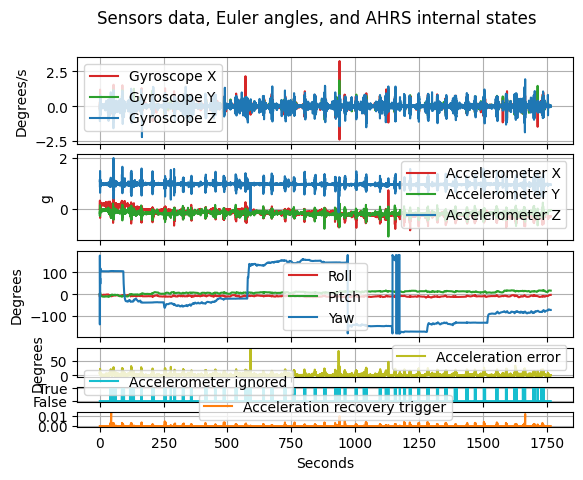

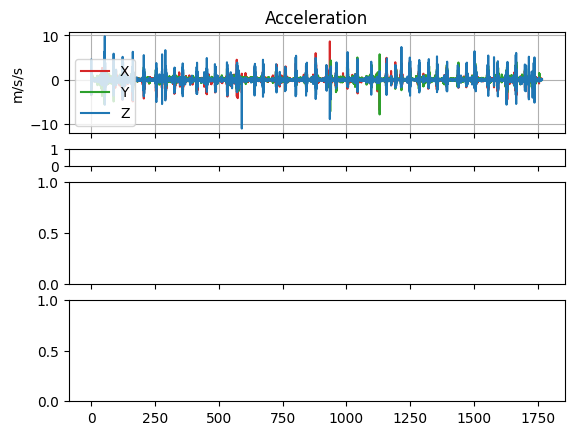

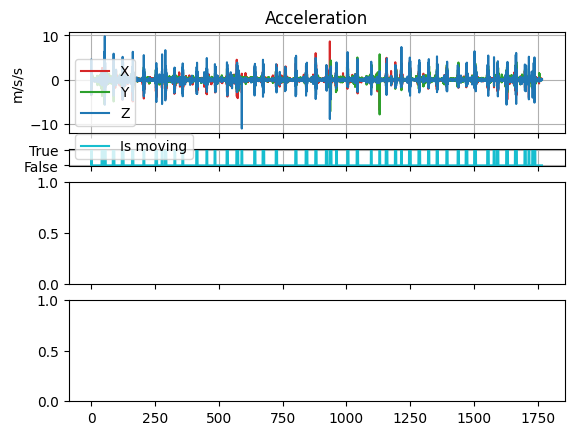

In [6]:
# Plot Euler angles
axes[2].plot(timestamp, euler[:, 0], "tab:red", label="Roll")
axes[2].plot(timestamp, euler[:, 1], "tab:green", label="Pitch")
axes[2].plot(timestamp, euler[:, 2], "tab:blue", label="Yaw")
axes[2].set_ylabel("Degrees")
axes[2].grid()
axes[2].legend()

# Plot internal states
axes[3].plot(timestamp, internal_states[:, 0], "tab:olive", label="Acceleration error")
axes[3].set_ylabel("Degrees")
axes[3].grid()
axes[3].legend()

axes[4].plot(timestamp, internal_states[:, 1], "tab:cyan", label="Accelerometer ignored")
pyplot.sca(axes[4])
pyplot.yticks([0, 1], ["False", "True"])
axes[4].grid()
axes[4].legend()

axes[5].plot(timestamp, internal_states[:, 2], "tab:orange", label="Acceleration recovery trigger")
axes[5].set_xlabel("Seconds")
axes[5].grid()
axes[5].legend()

# Plot acceleration
_, axes = pyplot.subplots(nrows=4, sharex=True, gridspec_kw={"height_ratios": [6, 1, 6, 6]})

axes[0].plot(timestamp, acceleration[:, 0], "tab:red", label="X")
axes[0].plot(timestamp, acceleration[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp, acceleration[:, 2], "tab:blue", label="Z")
axes[0].set_title("Acceleration")
axes[0].set_ylabel("m/s/s")
axes[0].grid()
axes[0].legend()
pyplot.show()
# Identify moving periods
is_moving = numpy.empty(len(timestamp))

for index in range(len(timestamp)):
    is_moving[index] = numpy.sqrt(acceleration[index].dot(acceleration[index])) > 3.7  # threshold = 3 m/s/s

margin = int(0.1 * sample_rate)  # 100 ms

for index in range(len(timestamp) - margin):
    is_moving[index] = any(is_moving[index:(index + margin)])  # add leading margin

for index in range(len(timestamp) - 1, margin, -1):
    is_moving[index] = any(is_moving[(index - margin):index])  # add trailing margin

# Plot moving periods
axes[1].plot(timestamp, is_moving, "tab:cyan", label="Is moving")
pyplot.sca(axes[1])
pyplot.yticks([0, 1], ["False", "True"])
axes[1].grid()
axes[1].legend()
pyplot.show()

In [15]:
acc_norm = numpy.zeros(len(timestamp))

for index in range(len(timestamp)):
    acc_norm[index] = numpy.sqrt(acceleration[index].dot(acceleration[index]))  # threshold = 3 m/s/s


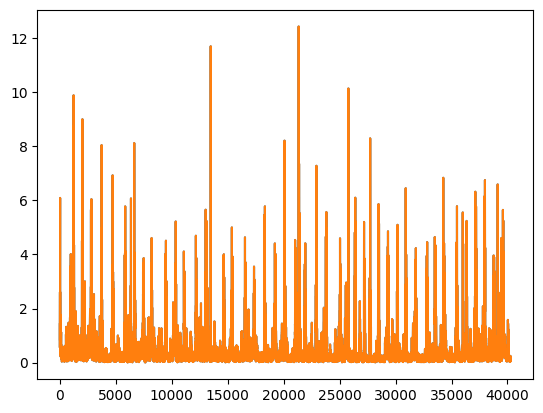

In [17]:
plt.plot(acc_norm)
plt.show()

In [12]:

# Calculate velocity (includes integral drift)
velocity = numpy.zeros((len(timestamp), 3))

for index in range(len(timestamp)):
    if is_moving[index]:  # only integrate if moving
        velocity[index] = velocity[index - 1] + delta_time[index] * acceleration[index]

# Find start and stop indices of each moving period
is_moving_diff = numpy.diff(is_moving, append=is_moving[-1])


@dataclass
class IsMovingPeriod:
    start_index: int = -1
    stop_index: int = -1


is_moving_periods = []
is_moving_period = IsMovingPeriod()

for index in range(len(timestamp)):
    if is_moving_period.start_index == -1:
        if is_moving_diff[index] == 1:
            is_moving_period.start_index = index

    elif is_moving_period.stop_index == -1:
        if is_moving_diff[index] == -1:
            is_moving_period.stop_index = index
            is_moving_periods.append(is_moving_period)
            is_moving_period = IsMovingPeriod()

# Remove integral drift from velocity
velocity_drift = numpy.zeros((len(timestamp), 3))

for is_moving_period in is_moving_periods:
    start_index = is_moving_period.start_index
    stop_index = is_moving_period.stop_index

    t = [timestamp[start_index], timestamp[stop_index]]
    x = [velocity[start_index, 0], velocity[stop_index, 0]]
    y = [velocity[start_index, 1], velocity[stop_index, 1]]
    z = [velocity[start_index, 2], velocity[stop_index, 2]]

    t_new = timestamp[start_index:(stop_index + 1)]

    velocity_drift[start_index:(stop_index + 1), 0] = interp1d(t, x)(t_new)
    velocity_drift[start_index:(stop_index + 1), 1] = interp1d(t, y)(t_new)
    velocity_drift[start_index:(stop_index + 1), 2] = interp1d(t, z)(t_new)

velocity = velocity - velocity_drift

#Rotate the velocity
yaw_angle = 120
velocity_new = rotate_trajectory(velocity, yaw_angle)
# Calculate position
position = numpy.zeros((len(timestamp), 3))

for index in range(len(timestamp)):
    position[index] = position[index - 1] + delta_time[index] * velocity[index]

    # Print error as distance between start and final positions
print("Error: " + "{:.3f}".format(numpy.sqrt(position[-1].dot(position[-1]))) + " m")

Error: 17.404 m


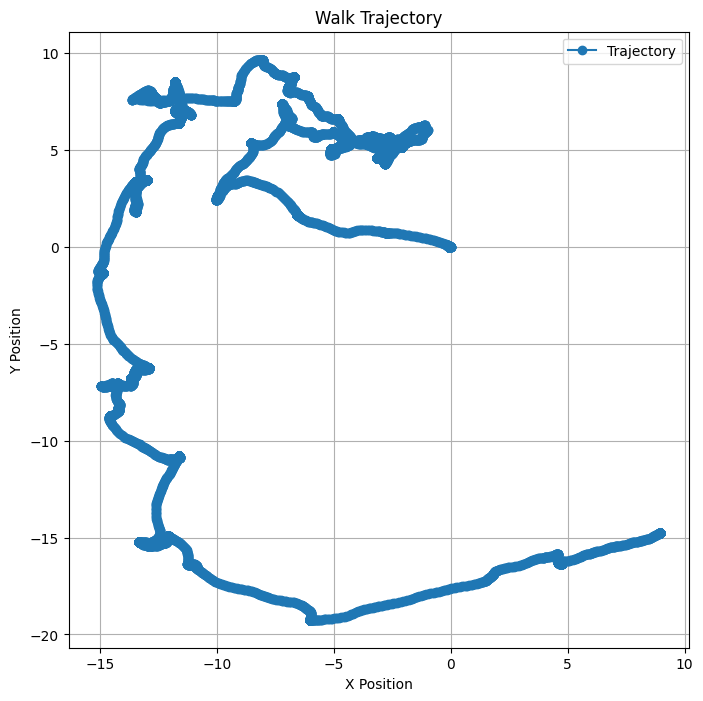

In [13]:

import matplotlib.pyplot as plt

figure_w = plt.figure(figsize=(8, 8))
plt.plot(position[:, 0], position[:, 1], marker='o', label='Trajectory')
#plt.plot(trajectory_x[:s], label='Trajectory_x')
#plt.plot(trajectory_y_reflected[:s], label='Trajectory_y')
# Display total distance on plot
#plt.text(0, reference_y * 1.05, f'Total Distance: {total_distance:.2f} meters', fontsize=10, ha='center')

plt.title('Walk Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
len(position[:, 0])

40300

In [21]:
euler[20:40, 2]

array([174.63444519, 174.62028503, 174.64465332, 174.70166016,
       174.73883057, 174.80749512, 174.83958435, 174.87059021,
       174.90756226, 174.87399292, 174.85279846, 174.89805603,
       174.89764404, 174.84173584, 174.80142212, 174.77900696,
       174.76048279, 174.73983765, 174.75622559, 174.76919556])

In [1]:
import numpy as np
arr = [(718, 596), (698, 551), (664, 519), (628, 513), (586, 508), (542, 526), (478, 568), (451, 620), (391, 644), (330, 646), (267, 645), (147, 585), (140, 490), (227, 419), (222, 356), (220, 292), (216, 239), (213, 144), (299, 138), (375, 131), (449, 128), (544, 125), (626, 124), (770, 124), (778, 182), (774, 230), (772, 284), (771, 328), (770, 364), (771, 404), (773, 455), (774, 514), (771, 565), (718, 596)]
arr_gt = np.array(arr)


In [32]:
import numpy as np
arr = [(718, 596), (698, 551), (698, 551), (664, 519), (628, 513), (628, 513), (586, 508), (586, 508), (542, 526), (478, 568), (478, 568), (451, 620), (451, 620), (391, 644), (330, 646),  (330, 646), (267, 645), (267, 645), (147, 585), (147, 585), (140, 490), (140, 490), (227, 419),(227, 419), (222, 356), (220, 292), (216, 239), (213, 144), (299, 138), (375, 131), (449, 128), (544, 125), (544, 125), (544, 125), (626, 124), (770, 124), (778, 182), (774, 230), (772, 284), (772, 284), (771, 328), (770, 364), (770, 364), (770, 364), (771, 404), (773, 455), (773, 455), (774, 514), (771, 565), (771, 565), (718, 596)]
arr_gt = np.array(arr)


In [2]:
arr_gt.shape

(34, 2)

In [3]:
# final on tuesday
arr = [(712, 590), (703, 562), (684, 511), (641, 495), (601, 489), (557, 494), (553, 540), (525, 569), (489, 577), (459, 609), (409, 641), (374, 643), (336, 643), (286, 643), (242, 633), (232, 581), (237, 542), (234, 485), (232, 426), (229, 382), (228, 342), (228, 298), (223, 259), (270, 243), (320, 244), (374, 248), (426, 243), (426, 199), (421, 151), (462, 133), (503, 129), (552, 127), (610, 128), (653, 129), (703, 129), (741, 132), (782, 139), (778, 173), (779, 215), (778, 265), (775, 318), (774, 348), (773, 383), (775, 430), (776, 482), (778, 538)]
arr_gt = np.array(arr)
arr_gt.shape

(46, 2)

In [34]:
is_moving[is_moving==1].shape

(6076,)

In [35]:
# Clean the data
cleaned_data = clean_data(is_moving)

# Count the steps (transitions from 0 to 1)
steps = count_steps(cleaned_data)

print("Cleaned Data:", cleaned_data)
print("Number of Steps:", steps)

Cleaned Data: [1 1 1 ... 0 0 0]
Number of Steps: 50


In [36]:
# Count the steps (transitions from 0 to 1)
steps = count_steps(is_moving)

#print("Cleaned Data:", cleaned_data)
print("Number of Steps:", steps)
print(is_moving.shape)

Number of Steps: 51
(40300,)


In [37]:
steps, step_indices = count_steps_and_indices(is_moving)
#print("Cleaned Data:", cleaned_data)
print("Number of Steps:", steps)
print("Step Indices:", step_indices)
new_gt_arr = numpy.zeros((is_moving.shape[0],2))
for i in range(steps):
    new_gt_arr[step_indices[i],:] = arr_gt[i,:]

Number of Steps: 51
Step Indices: [41, 936, 1147, 1937, 2740, 3654, 4674, 5757, 6312, 6605, 7450, 8159, 9405, 10313, 11040, 12116, 12989, 13441, 14581, 15332, 16504, 18248, 19174, 20036, 20983, 21302, 21893, 22888, 23731, 24998, 25746, 26323, 27145, 27692, 28402, 29246, 30101, 30869, 31739, 32747, 33467, 34225, 35392, 35968, 36248, 37090, 37872, 38728, 39085, 39421, 39519]


In [38]:
new_gt_arr = numpy.zeros((is_moving.shape[0],2))

In [46]:
new_gt_arr[131]

array([718., 596.])

In [55]:
new_gt_arr.shape[0]

36193

In [39]:
def replace_zeros_with_previous_non_zero(arr):
    # Ensure the input is a numpy array
    arr = np.array(arr)
    
    # Initialize the previous non-zero value as None
    previous_non_zero = np.array([718., 596.])
    
    # Iterate through the array
    for i in range(arr.shape[0]):
        if arr[i][0] != 0.0:
            previous_non_zero = arr[i]
        elif arr[i][0] == 0.0 and previous_non_zero is not None:
            arr[i] = previous_non_zero
            
    return arr

In [40]:
new_gt_big = replace_zeros_with_previous_non_zero(new_gt_arr)

In [41]:
def count_steps_and_indices(cleaned_data):
    steps = 0
    step_indices = []
    previous_value = cleaned_data[0]
    
    for i, value in enumerate(cleaned_data):
        if previous_value == 0 and value == 1:
            steps += 1
            step_indices.append(i)
        previous_value = value
    
    return steps, step_indices

In [42]:
def clean_data(data, segment_size=20):
    cleaned_data = []
    count_zeros = 0
    count_ones = 0
    
    for value in data:
        if value == 0:
            count_zeros += 1
            if count_zeros == segment_size:
                cleaned_data.extend([0] * segment_size)
                count_zeros = 0
                count_ones = 0
        elif value == 1:
            count_ones += 1
            if count_ones == segment_size:
                cleaned_data.extend([1] * segment_size)
                count_ones = 0
                count_zeros = 0
    
    return np.array(cleaned_data)

def count_steps(cleaned_data):
    steps = 0
    previous_value = cleaned_data[0]
    
    for value in cleaned_data:
        if previous_value == 0 and value == 1:
            steps += 1
        previous_value = value
    
    return steps

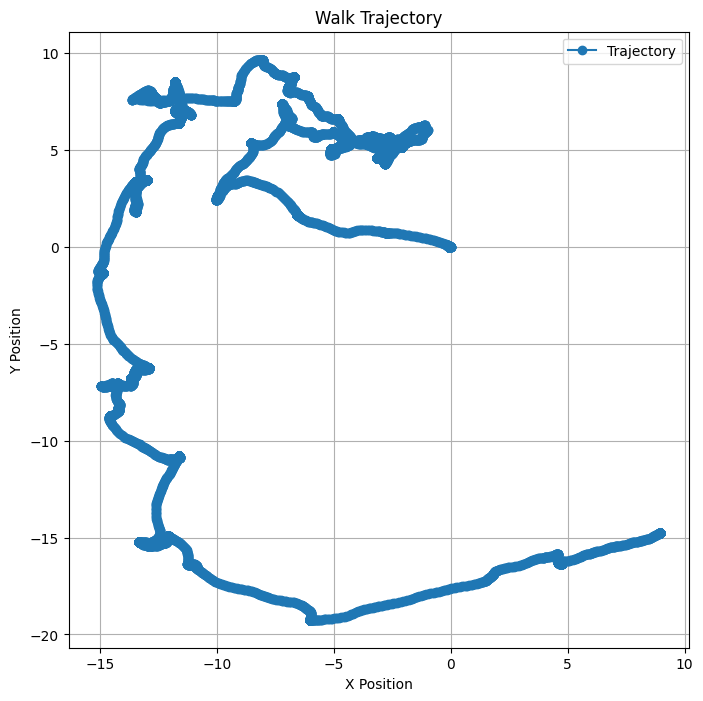

In [43]:
import matplotlib.pyplot as plt

figure_w = plt.figure(figsize=(8, 8))
plt.plot(position[:, 0], position[:, 1], marker='o', label='Trajectory')
#plt.plot(trajectory_x[:s], label='Trajectory_x')
#plt.plot(trajectory_y_reflected[:s], label='Trajectory_y')
# Display total distance on plot
#plt.text(0, reference_y * 1.05, f'Total Distance: {total_distance:.2f} meters', fontsize=10, ha='center')

plt.title('Walk Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.show()


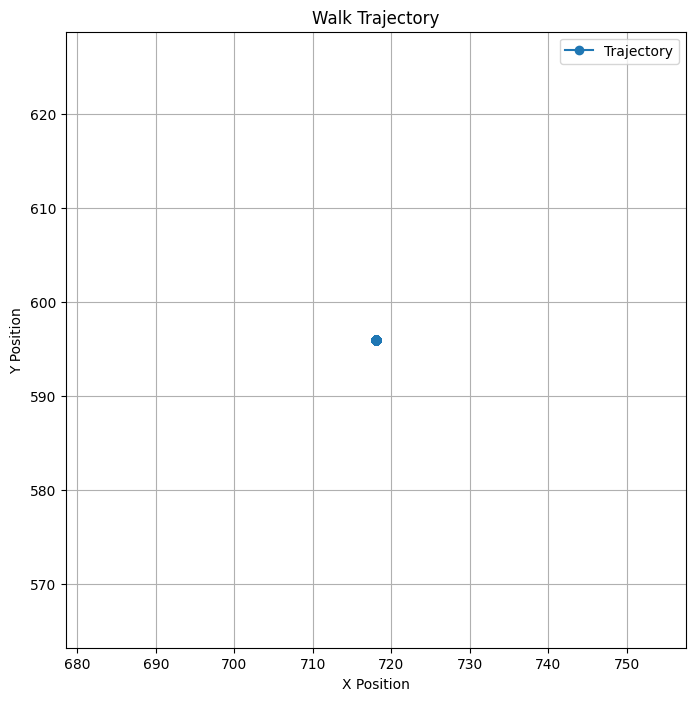

In [44]:

import matplotlib.pyplot as plt

figure_w = plt.figure(figsize=(8, 8))
plt.plot(new_gt_big[:, 0], new_gt_big[:, 1], marker='o', label='Trajectory')
#plt.plot(trajectory_x[:s], label='Trajectory_x')
#plt.plot(trajectory_y_reflected[:s], label='Trajectory_y')
# Display total distance on plot
#plt.text(0, reference_y * 1.05, f'Total Distance: {total_distance:.2f} meters', fontsize=10, ha='center')

plt.title('Walk Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.show()

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import procrustes

def procrustes_analysis(X, Y):
    # Ensure inputs are numpy arrays
    X = np.array(X)
    Y = np.array(Y)
    
    # Apply Procrustes analysis
    mtx1, mtx2, disparity = procrustes(X, Y)
    
    # Calculate translation and rotation
    translation = mtx2.mean(axis=0) - mtx1.mean(axis=0)
    rotation, scale = get_rotation_scale(mtx1, mtx2)
    
    return mtx1, mtx2, translation, rotation, scale, disparity

def get_rotation_scale(X, Y):
    # Center the data
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    
    # Singular value decomposition
    U, _, Vt = np.linalg.svd(np.dot(Yc.T, Xc))
    
    # Rotation matrix
    R = np.dot(U, Vt)
    
    # Scale factor
    scale = np.sum(np.diag(np.dot(U, Vt))) / np.sum(Yc ** 2)
    
    return R, scale

In [46]:
#new_gt_big,  #
mtx1, mtx2, translation, rotation, scale, disparity = procrustes_analysis(new_gt_big, pose_imu)

print("Translation:", translation)
print("Rotation Matrix:\n", rotation)
print("Scale Factor:", scale)
print("Disparity (Error):", disparity)

NameError: name 'pose_imu' is not defined

In [47]:
plt.plot(mtx1[:, 0], mtx1[:, 1], 'bo-', label='Trajectory 1 (Aligned)')
plt.plot(mtx2[:, 0], mtx2[:, 1], 'ro-', label='Trajectory 2 (Aligned)')
plt.title('Aligned Trajectories')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'mtx1' is not defined

In [60]:
position.shape

(36193, 3)

In [48]:
pose_imu = np.zeros((position.shape[0],2))
pose_imu[:,0]=position[:,0]
pose_imu[:,1]=position[:,1]

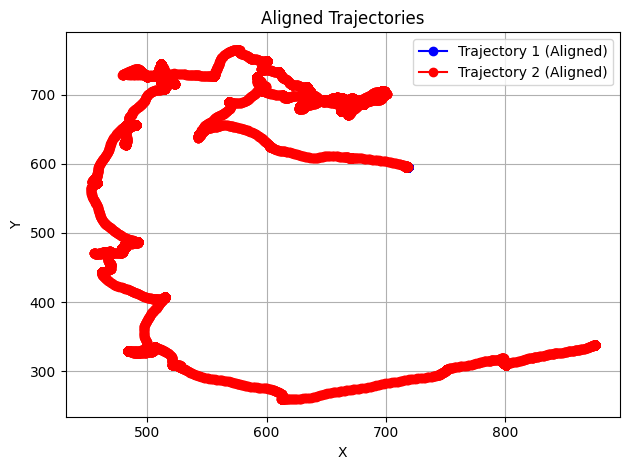

In [49]:
k = 17.5
plt.plot(new_gt_big[:, 0], new_gt_big[:, 1], 'bo-', label='Trajectory 1 (Aligned)')
plt.plot(k*pose_imu[:, 0]+new_gt_big[0,0], k*pose_imu[:, 1]+new_gt_big[0,1], 'ro-', label='Trajectory 2 (Aligned)')
plt.title('Aligned Trajectories')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [77]:
new_gt_big[0]

array([718., 596.])

In [78]:
pos_imu_pro = np.zeros((pose_imu.shape[0],pose_imu.shape[1]))
k = 17.5
for i in range(pose_imu.shape[0]):
    pos_imu_pro[i,0] = k*pose_imu[i, 0]+new_gt_big[0,0]
    pos_imu_pro[i,1] = k*pose_imu[i, 1]+new_gt_big[0,1]
    

In [79]:
def calculate_rotation_matrix(X, Y):
    # Ensure inputs are numpy arrays
    X = np.array(X)
    Y = np.array(Y)
    
    # Center the data
    X_centered = X - X.mean(axis=0)
    Y_centered = Y - Y.mean(axis=0)
    
    # Singular value decomposition
    U, _, Vt = np.linalg.svd(np.dot(Y_centered.T, X_centered))
    
    # Rotation matrix
    R = np.dot(U, Vt)
    
    # Apply rotation to Y
    Y_rotated = np.dot(Y_centered, R.T)
    
    # Calculate disparity (sum of squared differences)
    disparity = np.sum((X_centered - Y_rotated) ** 2)
    
    return R, disparity

In [80]:
rotation_matrix, disparity = calculate_rotation_matrix(new_gt_big, pos_imu_pro)

print("Rotation Matrix:\n", rotation_matrix)
print("Disparity (Error):", disparity)

Rotation Matrix:
 [[-0.56780968  0.82315987]
 [-0.82315987 -0.56780968]]
Disparity (Error): 6777793361.32114


In [83]:
#trajectory2_centered = pos_imu_pro - pos_imu_pro.mean(axis=0)
trajectory2_rotated = np.dot(trajectory2_centered, rotation_matrix.T) #+ new_gt_big.mean(axis=0)


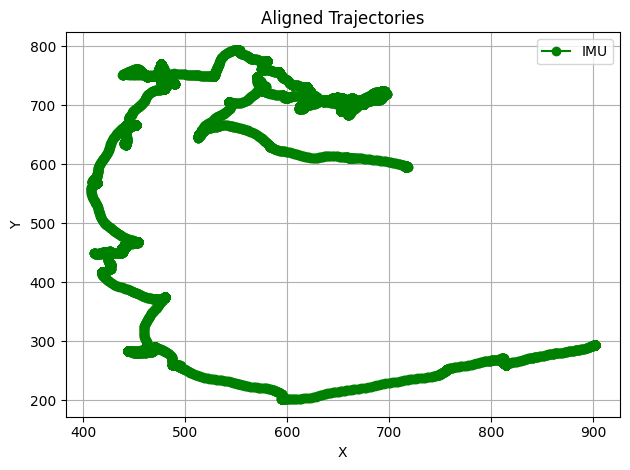

In [53]:


pos_imu_pro = np.zeros((pose_imu.shape[0],pose_imu.shape[1]))
k = 20.5
for i in range(pose_imu.shape[0]):
    pos_imu_pro[i,0] = k*pose_imu[i, 0]+new_gt_big[0,0]
    pos_imu_pro[i,1] = k*pose_imu[i, 1]+new_gt_big[0,1]
    
yaw_angle = 120 # in degrees
rotated_trajectory = pos_imu_pro #rotate_trajectory(pos_imu_pro, yaw_angle)

#plt.plot(new_gt_big[:, 0], new_gt_big[:, 1], 'bo-', label='Ground truth (Aligned)')
#plt.plot(pos_imu_pro[:, 0], pos_imu_pro[:, 1], 'ro-', label='IMU')
plt.plot(rotated_trajectory[:, 0], rotated_trajectory[:, 1], 'go-', label='IMU')
plt.title('Aligned Trajectories')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print(int(new_gt_big[i, 0],int(new_gt_big[i, 1])
print(int(new_gt_big[i, 0],int(new_gt_big[i, 1])
                   

In [11]:

def rotate_trajectory(trajectory, yaw_angle):
    # Ensure the input is a numpy array
    trajectory = np.array(trajectory)
    
    # Convert yaw angle to radians
    yaw_rad = np.deg2rad(yaw_angle)
    
    # Get the initial point (starting point of the array)
    initial_point = trajectory[0]
    
    # Create the rotation matrix
    rotation_matrix = np.array([
        [np.cos(yaw_rad), -np.sin(yaw_rad),0],
        [np.sin(yaw_rad), np.cos(yaw_rad), 0],
        [0, 0, 1]
    ])
    
    # Translate trajectory to the origin (subtract the initial point)
    translated_trajectory = trajectory - initial_point
    
    # Apply the rotation matrix
    rotated_translated_trajectory = np.dot(translated_trajectory, rotation_matrix.T)
    
    # Translate back to the initial point (add the initial point)
    rotated_trajectory = rotated_translated_trajectory + initial_point
    
    return rotated_trajectory

1830x1167


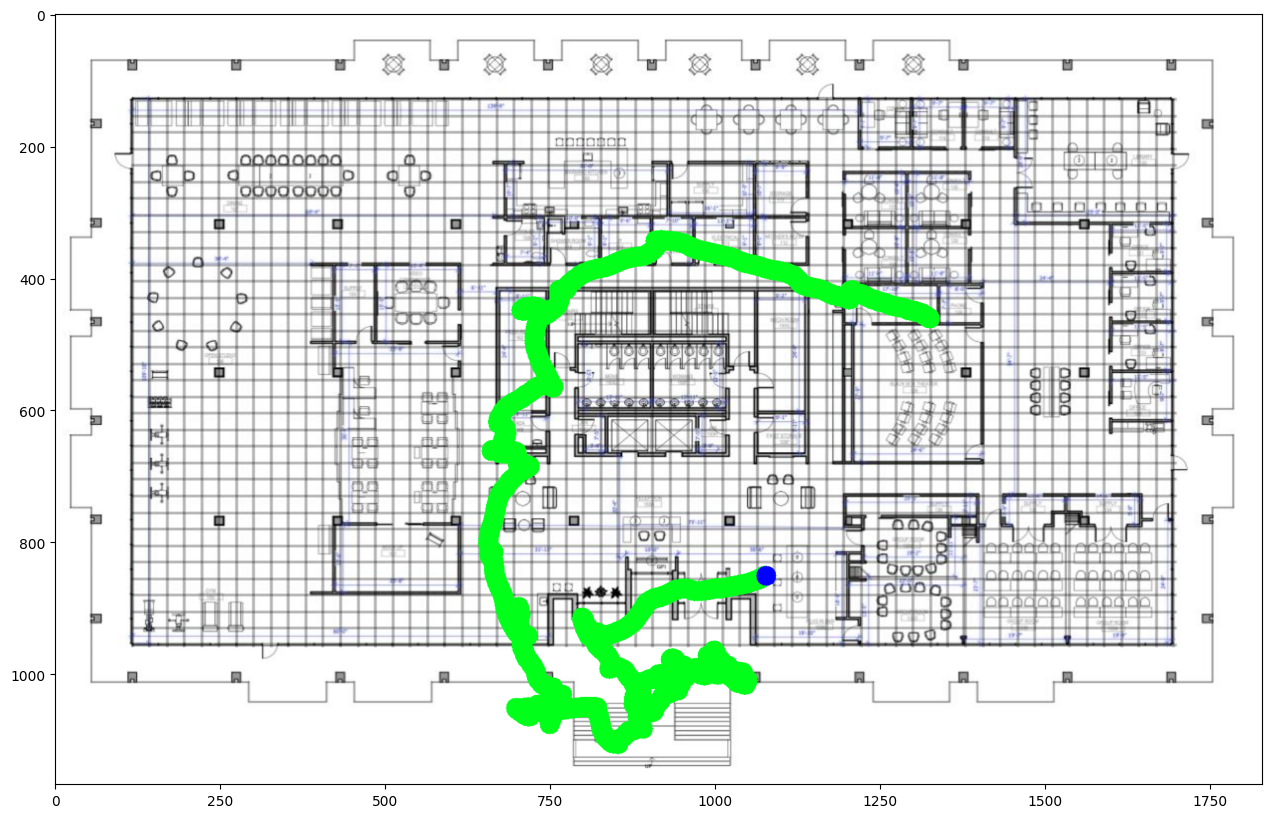

In [57]:
import cv2
img = cv2.imread("ep6_floorplan_measured_half_gridded_1_meter.jpg", cv2.IMREAD_COLOR)
img = cv2.resize(img, (610*3, 389*3))
wid = img.shape[1]
hgt = img.shape[0]
img = cv2.resize(img, (610*3, 389*3))
print(str(wid) + "x" + str(hgt))


pos_imu_pro = np.zeros((pose_imu.shape[0],pose_imu.shape[1]))
k = 18.5
for i in range(pose_imu.shape[0]):
    pos_imu_pro[i,0] = k*pose_imu[i, 0]+new_gt_big[0,0]
    pos_imu_pro[i,1] = k*pose_imu[i, 1]+new_gt_big[0,1]
    
rotated_trajectory = pos_imu_pro
color=[0,0,255] 

# for i in range(0, len(df)):
#     image = cv2.circle(img, (int(df['X'][i] * 1830/1220), int(df['Y'][i] * 1167/817)), 15, color , -1)
color_2=[0,0,255]
color_1=[0,255,25]

for i in range(0, rotated_trajectory.shape[0]):
    image = cv2.circle(img, (int(rotated_trajectory[i, 0] * 1830/1220), int(rotated_trajectory[i, 1] * 1167/817)), 15, color_1 , -1)

for i in range(0, rotated_trajectory.shape[0]):
    image = cv2.circle(img, (int(new_gt_big[i, 0] * 1830/1220), int(new_gt_big[i, 1] * 1167/817)), 15, color_2 , -1)

    
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

In [96]:
print(new_gt_big[1, 0],new_gt_big[1, 1])

718.0 596.0


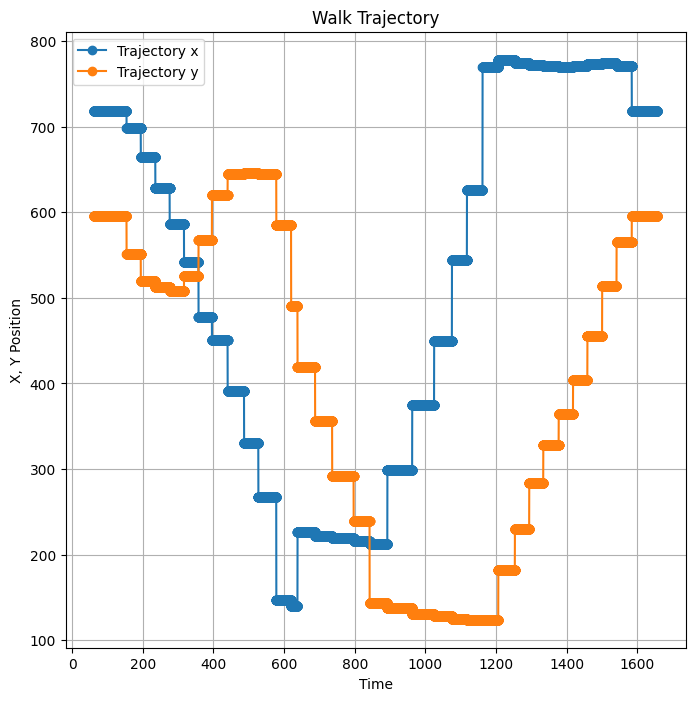

In [95]:
# plt.plot(new_gt_big[:, 0], new_gt_big[:, 1], 'bo-', label='Ground truth (Aligned)')
# plt.plot(trajectory2_rotated[:, 0], trajectory2_rotated[:, 1], 'ro-', label='IMU')
# plt.title('Aligned Trajectories')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.grid(True)

figure_y = plt.figure(figsize=(8, 8))
plt.plot(timestamp, new_gt_big[:, 0], marker='o', label='Trajectory x')
plt.plot(timestamp, new_gt_big[:, 1], marker='o', label='Trajectory y')
#plt.plot(trajectory_x[:s], label='Trajectory_x')
#plt.plot(trajectory_y_reflected[:s], label='Trajectory_y')
# Display total distance on plot
#plt.text(0, reference_y * 1.05, f'Total Distance: {total_distance:.2f} meters', fontsize=10, ha='center')

plt.title('Walk Trajectory')
plt.xlabel('Time')
plt.ylabel('X, Y Position')
plt.grid(True)
plt.legend()
plt.show()